In [67]:
from __future__ import division, print_function

import time
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt

import sncosmo
from astropy.table import Table

# Used to normalise features
from sklearn.preprocessing import StandardScaler 
# Used for hyperparameter optimisation and to avoid overfitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Some example algorithms you can try using (sklearn has many more)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from astropy.cosmology import Planck15 as cosmo 
from astropy.io import fits
%matplotlib inline

In [68]:
sn_machine='/Users/mariavincenzi/PhD/SNChallenge/supernova-machine/'

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import time

import sys
import os
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
max_ml_algorithms_file=sn_machine+'max_ml_algorithms.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_ml_algorithms_file)))
import max_ml_algorithms as ml_algorithms#, max_tools as tools
max_tools_file=sn_machine+'max_tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_tools_file)))
import max_tools as tools

In [69]:
def prepare_data4ml_algorithms(feats_file, which_feat, which_feat_err):
    f = np.array(feats_file[:, which_feat], dtype='float')
    err = np.array(feats_file[:, which_feat_err], dtype='float')
    types = np.array(feats_file[:, 1], dtype='int')

    X = f[types!=-9, :]
    Y = types[types!=-9]
    X_err = err[types!=-9, :]

    X_scaled, X_err_scaled, mean,std= tools.scale_data_with_errors(X, X_err)
    X_combined = np.concatenate((X_scaled, X_err_scaled), axis=1)

    #Combine classes into Ia (Y=1), II (Y=2), and Ib and Ic (Y=3)
    Y[(Y==21) | (Y==22) | (Y==23)]=2
    Y[(Y==32) | (Y==33)]=3
    
    return X_combined, Y, X_scaled.shape[1], mean, std

def scale_data(X, m=[None], std=[None], ret=False):
    """
    Scale all data to be distributed about mean = 0 with std = 1. Scale the feature errors by the 
    same factor.
    
    INPUTS:
    X - An array containing all the features, of size (N_samples, N_features)
    
    OUTPUTS:
    X_scaled - An array containing all scaled features, of size (N_samples, N_features)
    """
    if len(m)==4:
        sigma = std
        mean = m
    else:
        sigma = np.std(X, axis=0)
        mean = np.mean(X, axis=0)

    X_scaled = -999*np.ones(X.shape)
    
    for counter in np.arange(len(sigma)):
        X_scaled[:, counter] = (X[:, counter]-mean[counter]*np.ones(X.shape[0]))/sigma[counter]
    
    if ret:
        return X_scaled, mean, sigma
    else:
        return X_scaled



In [70]:
def run_ml_plot(X_combined, Y, Shape):
    #Preallocate results table for multiple runs
    #NOTE I'M HARD CODING THE NUMBER OF CLASSIFIERS AND PERFORMANCE
    #CRITERION HERE
    N_runs = 1
    N_classifiers = 7
    N_scores = 3
    results = -999*np.ones([N_classifiers, N_scores, N_runs])
    thresholds = -999*np.ones([N_classifiers, N_scores-1, N_runs])

    #Run classifiers and return AUC, FoM and F1 for each
    for run_counter in np.arange(N_runs):
       
        X_train_combined, X_test_combined, Y_train, Y_test = train_test_split(
        X_combined, Y, test_size=0.5, random_state=np.random.randint(100))
        
        #Seperate features and errors again
        X_train = X_train_combined[:, :Shape]
        X_train_err = X_train_combined[:, Shape:]
        X_test = X_test_combined[:, :Shape]
        X_test_err = X_test_combined[:, Shape:]
        
        #Run classifiers
        results_temp, thresholds_temp, P_RF_test, P_RF_train = tools.run_ml(X_train, Y_train, X_test, Y_test, X_train_err, X_test_err)
        results[:, :, run_counter] = results_temp
        thresholds[:, :, run_counter] = thresholds_temp
        
        #Clean up a bit
        del results_temp, thresholds_temp, X_train_combined, X_test_combined
        
    return results, thresholds, P_RF_test, P_RF_train, X_test, X_test_err, Y_test, X_train, X_train_err, Y_train




In [71]:
start = time.time()

feats_log10 = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete_log10x0_mb_cov.txt',\
                            dtype='str', comments='#')


DES_zspec_to_xo_x1_c=[26,30,32,34]
DES_zspec_to_xo_x1_c_err=[27,31,33,35]


In [95]:
SDSSdata=np.genfromtxt('/Users/mariavincenzi/PhD/zBEAMS_pre_analysis/Campbell_reanalysis/sdsssn_master.dat2', names=True, dtype=None)

z=np.array(SDSSdata['z_best_with_BOSS_HELIO'], dtype=float)
SDSSdata['mu'][np.where(SDSSdata['mu']=='\\N')]=np.nan
mu=np.array(SDSSdata['mu'], dtype=float)
SDSSdata['c'][np.where(SDSSdata['c']=='\\N')]=np.nan
SALT_color=np.array(SDSSdata['c'], dtype=float)
SDSSdata['cerr'][np.where(SDSSdata['cerr']=='\\N')]=np.nan
SALT_color_err=np.array(SDSSdata['cerr'], dtype=float)
SDSSdata['x0'][np.where(SDSSdata['x0']=='\\N')]=np.nan
SALT_x0=np.array(SDSSdata['x0'], dtype=float)
SDSSdata['x1'][np.where(SDSSdata['x1']=='\\N')]=np.nan
SALT_x1=np.array(SDSSdata['x1'], dtype=float)
SDSSdata['x1err'][np.where(SDSSdata['x1err']=='\\N')]=np.nan
SALT_x1_err=np.array(SDSSdata['x1err'], dtype=float)
SDSSdata['chi2'][np.where(SDSSdata['chi2']=='\\N')]=np.nan
SALT_chi2=np.array(SDSSdata['chi2'], dtype=float)

SDSSdata['smp_mjd_peakmag_r'][np.where(SDSSdata['smp_mjd_peakmag_r']=='\\N')]=np.nan
MJD_peak_r=np.array(SDSSdata['smp_mjd_peakmag_r'], dtype=float)

SDSSdata['pz_ia'][np.where(SDSSdata['pz_ia']=='\\N')]=np.nan
SDSSdata['pz_ia'][np.where(SDSSdata['pz_ia']=='-9.0000')]=np.nan
SDSSdata['pz_ibc'][np.where(SDSSdata['pz_ibc']=='\\N')]=np.nan
SDSSdata['pz_ibc'][np.where(SDSSdata['pz_ibc']=='-9.0000')]=np.nan
SDSSdata['pz_ii'][np.where(SDSSdata['pz_ii']=='\\N')]=np.nan
SDSSdata['pz_ii'][np.where(SDSSdata['pz_ii']=='-9.0000')]=np.nan

p_ia=np.array(SDSSdata['pz_ia'], dtype=float)
p_ibc=np.array(SDSSdata['pz_ibc'], dtype=float)
p_ii=np.array(SDSSdata['pz_ii'], dtype=float)

index_valid_SN=([i for i in range(len(SDSSdata['cid']))\
     if (SDSSdata['z_best_with_BOSS_HELIO'][i]!=-9.)\
     &(SDSSdata['type_dr'][i]!='AGN')\
     &(SDSSdata['type_dr'][i]!='Variable')\
     &(~np.isnan(SALT_color[i]))\
    ])

z_SDSS=np.copy(z[index_valid_SN])
mu_SDSS=np.copy(mu[index_valid_SN])
SALT_color_SDSS=np.copy(SALT_color[index_valid_SN])
SALT_color_err_SDSS=np.copy(SALT_color_err[index_valid_SN])
SALT_x0_SDSS=np.copy(SALT_x0[index_valid_SN])
SALT_x1_SDSS=np.copy(SALT_x1[index_valid_SN])
SALT_x1_err_SDSS=np.copy(SALT_x1_err[index_valid_SN])
SALT_chi2_SDSS=np.copy(SALT_chi2[index_valid_SN])
MJD_peak_r_SDSS=np.copy(MJD_peak_r[index_valid_SN])
Pz_ia_PSNID=np.copy(p_ia[index_valid_SN])
P_ia_PSNID=np.copy(p_ia[index_valid_SN])
p_ibc_SDSS=np.copy(p_ibc[index_valid_SN])
p_ii_SDSS=np.copy(p_ii[index_valid_SN])

feats_SDSS = np.vstack((z_SDSS,\
                        np.log10(SALT_x0_SDSS), \
                        SALT_x1_SDSS,\
                        SALT_color_SDSS))

SDSS_zspec_to_xo_x1_c=[0,1,2,3,4]

/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [97]:
feats_SDSS.shape

(4, 2230)

In [98]:
def results_analysis(RES_XX):
    results, thresholds, P_RF_test, P_RF_train, X_test, X_test_err, Y_test, X_train, X_train_err, Y_train = RES_XX
    #concatenate:
    X=np.concatenate([X_test, X_train])
    Y=np.concatenate([Y_test, Y_train])
    Xerr=np.concatenate([X_test_err, X_train_err])

    P_RF=np.concatenate([P_RF_test, P_RF_train])

    Res_Class=np.array([1+np.argmax([P_RF[i,0], P_RF[i,1], P_RF[i,2]])\
                             for i in range(len(Y))])

    FN_Ia=((Res_Class!=1))&(Y==1)
    FP_Ia=((Res_Class==1))&(Y!=1)
    TP_Ia=((Res_Class==1))&(Y==1)
    TN_Ia=((Res_Class!=1))&(Y!=1)
    
    print ('FP', len(Y[FP_Ia]), 'FN', len(Y[FN_Ia]))
    print ('TP', len(Y[TP_Ia]), 'TN', len(Y[TN_Ia]))

    print ('########  purity: ', np.round(100.*float(len(Y[TP_Ia]))/(len(Y[FP_Ia])+len(Y[TP_Ia]))))
    print ('########  efficiency: ', np.round(100*float(len(Y[TP_Ia]))/(len(Y[FN_Ia])+len(Y[TP_Ia]))))
    
    Res_Class_chop= np.ones(len(Y))*2
    Res_Class_chop[P_RF[:,0]>0.95]= 1 
    
    FN_Ia_c=((Res_Class_chop!=1))&(Y==1)
    FP_Ia_c=((Res_Class_chop==1))&(Y!=1)
    TP_Ia_c=((Res_Class_chop==1))&(Y==1)
    TN_Ia_c=((Res_Class_chop!=1))&(Y!=1)
    print ('FP', len(Y[FP_Ia_c]), 'FN', len(Y[FN_Ia_c]))
    print ('TP', len(Y[TP_Ia_c]), 'TN', len(Y[TN_Ia_c]))
    
    print ('########  purity chopping: ', np.round(100.*float(len(Y[TP_Ia_c]))/(len(Y[FP_Ia_c])+len(Y[TP_Ia_c]))))
    print ('########  efficiency chopping: ', np.round(100*float(len(Y[TP_Ia_c]))/(len(Y[FN_Ia_c])+len(Y[TP_Ia_c]))))
    
    
    return X, Xerr, Y, P_RF

scale_data_with_errors [ 0.48599896 -4.99155179  0.53284972  0.08330253] [ 0.19422685  0.34419364  1.55601443  0.20544196]
KNN optimiser time taken: 0.736114025116
('FeatImp', array([ 0.23260917,  0.125211  ,  0.34632394,  0.29585589]))
('FeatImp', array([ 0.2257661 ,  0.11977176,  0.30364684,  0.35081531]))
('FeatImp', array([ 0.23692912,  0.12399837,  0.34370673,  0.29536579]))
('FeatImp', array([ 0.22170189,  0.12030092,  0.30274641,  0.35525077]))
('FeatImp', array([ 0.22620645,  0.12588617,  0.34810312,  0.29980426]))
('FeatImp', array([ 0.22785627,  0.11922628,  0.30396535,  0.34895209]))
('FeatImp', array([ 0.2309077 ,  0.12466812,  0.34643625,  0.29798793]))
('FeatImp', array([ 0.22359601,  0.11985378,  0.30139173,  0.35515848]))
('FeatImp', array([ 0.22532916,  0.12594884,  0.34941812,  0.29930388]))
('FeatImp', array([ 0.22738881,  0.11901176,  0.30117514,  0.35242429]))
RF optimisier time taken: 92.7387611866
('ARGS', (RandomForestClassifier(bootstrap=True, class_weight=None

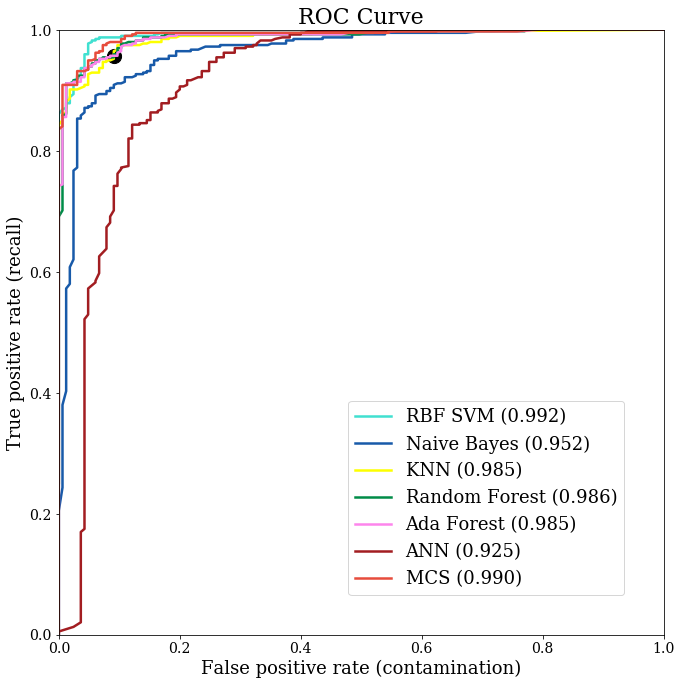

In [9]:
X_combined, Y_keys , Sh, mean_zsp, std_zsp= prepare_data4ml_algorithms(feats_log10, DES_zspec_to_xo_x1_c, DES_zspec_to_xo_x1_c_err)
RES_zsp=run_ml_plot(X_combined, Y_keys, Sh)

In [10]:
X_DES, Xerr_DES, Y_DES, Prob_DES= results_analysis(RES_zsp)

FP 29 FN 35
TP 745 TN 311
########  purity:  96.0
########  efficiency:  96.0
FP 1 FN 164
TP 616 TN 339
########  purity chopping:  100.0
########  efficiency chopping:  79.0


In [99]:

X_training=np.array(np.vstack((feats_log10[:,26],\
                               feats_log10[:,30],\
                               feats_log10[:,32],\
                               feats_log10[:,34],\
                              )), dtype=float).T

Y_training=np.array(feats_log10[:,1], dtype=float)
   
Y_training[(Y_training==21) | (Y_training==22) | (Y_training==23)]=2
Y_training[(Y_training==32) | (Y_training==33)]=3

X_testing=feats_SDSS.T

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training, X_testing))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_scaled = scale_data(X_training, global_mean, global_std)
X_testing_scaled = scale_data(X_testing, global_mean, global_std)

print (X_training.shape)
print (Y_training.shape)
print (X_testing.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing set
classifier.fit(X_training_scaled, Y_training)
probs=classifier.predict_proba(X_testing_scaled)    


(1120, 4)
(1120,)
(2230, 4)


In [100]:
P_ia_ML=probs[:,0]
type_classif=np.array([1+np.argmax([probs[i,0], probs[i,1], probs[i,2]])\
                             for i in range(len(probs[:,0]))])

print (len(P_ia_PSNID), len(P_ia_ML))

2230 2230


(array([ 1954.,   119.,    32.,    16.,    13.,    11.,    14.,    17.,
           33.,    21.]),
 array([  2.22044605e-16,   9.61666667e-02,   1.92333333e-01,
          2.88500000e-01,   3.84666667e-01,   4.80833333e-01,
          5.77000000e-01,   6.73166667e-01,   7.69333333e-01,
          8.65500000e-01,   9.61666667e-01]),
 <a list of 10 Patch objects>)

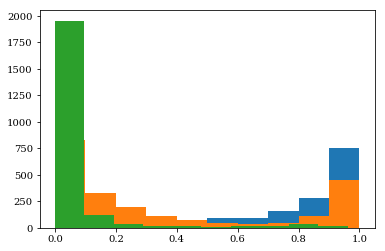

In [101]:
plt.hist(probs[:,0])
plt.hist(probs[:,1])
plt.hist(probs[:,2])

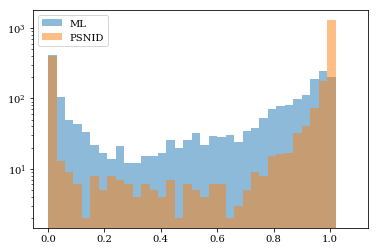

In [130]:
bb=np.arange(0,1.1,0.03)

plt.hist(P_ia_ML, bins=bb, alpha=0.5, log=True,label='ML')
plt.hist(P_ia_PSNID[~np.isnan(P_ia_PSNID)], bins=bb, alpha=0.5, label='PSNID')
#plt.hist(Pz_ia_PSNID[~np.isnan(Pz_ia_PSNID)], bins=bb, alpha=0.5, label='zPSNID')
plt.legend()

1502
533
413
494


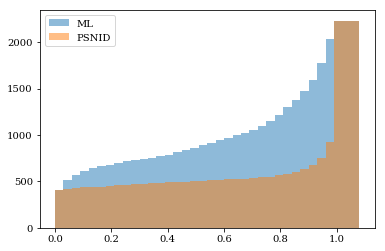

In [135]:
print (len(P_ia_PSNID[P_ia_PSNID>0.95]))
print (len(P_ia_ML[P_ia_ML>0.95]))

print (len(P_ia_PSNID[P_ia_PSNID<0.05]))
print (len(P_ia_ML[P_ia_ML<0.05]))



bb=np.arange(0,1.1,0.03)

plt.hist(P_ia_ML, bins=bb, alpha=0.5, cumulative=True,label='ML')
plt.hist(P_ia_PSNID[~np.isnan(P_ia_PSNID)], bins=bb, alpha=0.5,cumulative=True, label='PSNID')
plt.legend()

Text(0.5,0,u'P Ia PSNID - SNmachine P Ia')

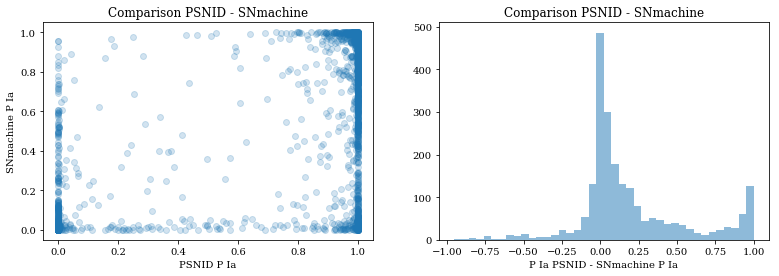

In [103]:
fg=plt.figure(1, figsize=(13,4))
plt.subplot(121)
plt.title('Comparison PSNID - SNmachine')
plt.plot(Pz_ia_PSNID, P_ia_ML, 'o', alpha=0.2)
plt.xlabel('PSNID P Ia')
plt.ylabel('SNmachine P Ia')

P_diff=(P_ia_PSNID-P_ia_ML)[~np.isnan(P_ia_PSNID/P_ia_ML)]
P_diff2=(Pz_ia_PSNID-P_ia_ML)[~np.isnan(Pz_ia_PSNID/P_ia_ML)]
plt.subplot(122)
plt.title('Comparison PSNID - SNmachine')
#plt.hist(P_diff, bins=40, alpha=0.5)
plt.hist(P_diff2, bins=40, alpha=0.5)
plt.xlabel('P Ia PSNID - SNmachine P Ia')



In [128]:
len(P_diff2)

2223

In [105]:
#boost_RF(X_train, Y_train, X_test, *args):
#ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
#            oob_score=False, random_state=None, verbose=0,
#            warm_start=False), 3

In [106]:
mu_training=30.-2.5*X_training[:,1]+0.26*X_training[:,2]-3.*X_training[:,3]


(35.7, 45)

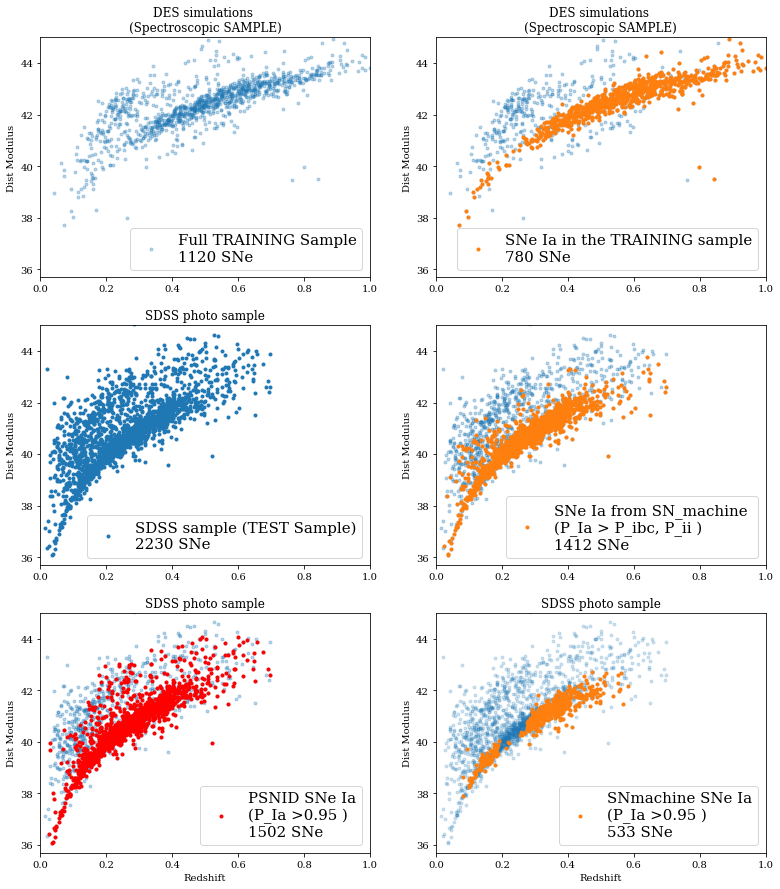

In [126]:
filterML=P_ia_ML>0.95

filterML_highestP=type_classif==1
filterPSNID=P_ia_PSNID>0.95
filtertraining= Y_training == 1


fig=plt.figure(1,figsize=(13,15))
plt.subplot(323)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS,#-cosmo.distmod(z_SDSS).value,\
         '.', label='SDSS sample (TEST Sample)\n%i SNe'%len(mu_SDSS))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='lower right', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)
plt.subplot(326)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS,#-cosmo.distmod(z_SDSS).value,\
         '.', alpha=0.2)
plt.plot(z_SDSS[filterML], mu_SDSS[filterML],#-cosmo.distmod(z_SDSS[filterML]).value,\
         '.', label='SNmachine SNe Ia\n(P_Ia >0.95 )\n%i SNe'%len(mu_SDSS[filterML]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='lower right', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)
mu_training=30.-2.5*X_training[:,1]+0.26*X_training[:,2]-3.*X_training[:,3]
plt.subplot(321)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training,#-cosmo.distmod(X_training[:,0]).value,\
         '.', alpha=0.3, label='Full TRAINING Sample\n%i SNe'%len(mu_training))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='lower right', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)
plt.subplot(322)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training, '.', alpha=0.3)
plt.plot(X_training[:,0][filtertraining], mu_training[filtertraining],#-cosmo.distmod(X_training[:,0][filtertraining]).value,\
         '.', label='SNe Ia in the TRAINING sample\n%i SNe'%len(mu_training[filtertraining]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='lower right', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)

plt.subplot(325)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS, '.', alpha=0.3)
plt.plot(z_SDSS[filterPSNID], mu_SDSS[filterPSNID],#-cosmo.distmod(z_SDSS[filterPSNID]).value,\
         'r.', label='PSNID SNe Ia\n(P_Ia >0.95 )\n%i SNe'%len(mu_SDSS[filterPSNID]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='lower right', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)


plt.subplot(324)
plt.plot(z_SDSS, mu_SDSS, '.', alpha=0.3)
plt.plot(z_SDSS[filterML_highestP], mu_SDSS[filterML_highestP],#-cosmo.distmod(z_SDSS[filterML_highestP]).value,\
         '.', label='SNe Ia from SN_machine \n(P_Ia > P_ibc, P_ii )\n%i SNe'%len(mu_SDSS[filterML_highestP]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='lower right', fontsize=15)
plt.xlim(0,1)
plt.ylim(35.7,45)#(-3,3)



0.147804 2.11662371215 0.478333333333 0.9968
0.387223 0.470967806595 0.085 1.0
0.110133 1.27190122225 0.713333333333 1.0
0.425016 1.29369514898 0.0716666666667 1.0
0.385316 0.406563135563 0.675 0.9999
0.458071 1.37300342197 0.111666666667 0.9966
0.60403 0.925438739517 0.156666666667 0.9922
0.264749 1.59786794038 0.501666666667 0.9855
0.198426 0.654476167814 0.255 1.0
0.261826 0.421142605843 0.476666666667 0.9999
0.218694 1.39966017886 0.015 1.0
0.199155 0.97279725138 2.22044604925e-16 0.9855
0.1072 1.19029124506 0.143333333333 1.0
0.098871 0.700076500297 0.788333333333 1.0
0.156311 0.927309988278 0.00166666666667 0.9188
0.189482 1.52593877123 2.22044604925e-16 0.216
0.473646 1.28391236451 0.0383333333333 0.6188
0.231249 0.994723876119 0.005 0.9982
0.259608 1.84057963887 0.518333333333 1.0
0.147189 1.96880704936 0.0283333333333 1.0
0.240564 1.65574163435 0.00666666666667 0.9453
0.249061 1.20343532373 0.52 0.9999
0.150203 0.8664339549 0.755 1.0
0.155771 0.880344098009 0.0483333333333 0.9

0.113209 0.637422201885 0.12 1.0
0.614351 0.514463027721 0.345 0.9999
0.626504 1.03307424164 0.428333333333 0.9624
0.471736 1.27637548082 0.00166666666667 1.0
0.220567 0.774354679495 0.131666666667 0.7833
0.217599 1.19949985375 0.365 0.5729
0.157665 1.07637965821 0.123333333333 1.0
0.409815 1.34025960294 0.0633333333333 1.0
0.185152 0.747961658233 2.22044604925e-16 0.9925
0.178292 1.08176533865 0.595 0.948
0.239904 2.54599129019 0.03 1.0
0.254845 0.650619990393 0.67 0.9981
0.154405 1.59269267423 0.465 1.0
0.260941 0.407516816137 0.57 0.9992
0.283252 2.09406069915 0.0116666666667 0.9954
0.418128 1.80155665545 0.005 0.9947
0.344305 1.8463603042 2.22044604925e-16 0.8527
0.178524 1.0020418989 0.698333333333 1.0
0.336125 2.24439743579 0.015 0.9899
0.266266 1.46571877309 0.0233333333333 0.4905
0.177108 2.33256461123 0.005 0.9622
0.334672 1.20412817655 0.0316666666667 1.0
0.169122 1.10084619021 0.648333333333 0.9918
0.252729 1.81269343874 0.00833333333333 0.9516
0.167795 0.700589433296 0.5183

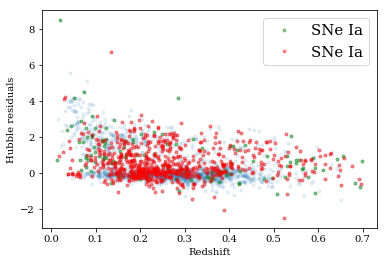

In [109]:
PML_lgr= P_ia_ML > P_ia_PSNID+0.2
PML_lor= P_ia_ML < P_ia_PSNID-0.2



plt.plot(z_SDSS, mu_SDSS-cosmo.distmod(z_SDSS).value, '.', alpha=0.1)
plt.plot(z_SDSS[PML_lgr], mu_SDSS[PML_lgr]-cosmo.distmod(z_SDSS[PML_lgr]).value, \
         '.g',alpha=0.4, label='SNe Ia')
plt.plot(z_SDSS[PML_lor], mu_SDSS[PML_lor]-cosmo.distmod(z_SDSS[PML_lor]).value, \
         '.r',alpha=0.4, label='SNe Ia')
plt.xlabel('Redshift')
plt.ylabel('Hubble residuals')
plt.legend(loc='best', fontsize=15)

for i in range(len(P_ia_ML[PML_lor])):
    if (mu_SDSS[PML_lor][i]-cosmo.distmod(z_SDSS[PML_lor][i]).value)>0.4:
        print (z_SDSS[PML_lor][i], \
           mu_SDSS[PML_lor][i]-cosmo.distmod(z_SDSS[PML_lor][i]).value, \
           P_ia_ML[PML_lor][i],  P_ia_PSNID[PML_lor][i])
print ('##')
for i in range(len(P_ia_ML[PML_lgr])):
    if (mu_SDSS[PML_lgr][i]-cosmo.distmod(z_SDSS[PML_lgr][i]).value)>0.4:
        print (z_SDSS[PML_lgr][i], \
           mu_SDSS[PML_lgr][i]-cosmo.distmod(z_SDSS[PML_lgr][i]).value, \
           P_ia_ML[PML_lgr][i],  P_ia_PSNID[PML_lgr][i])

Text(0.5,0,u' Redshift')

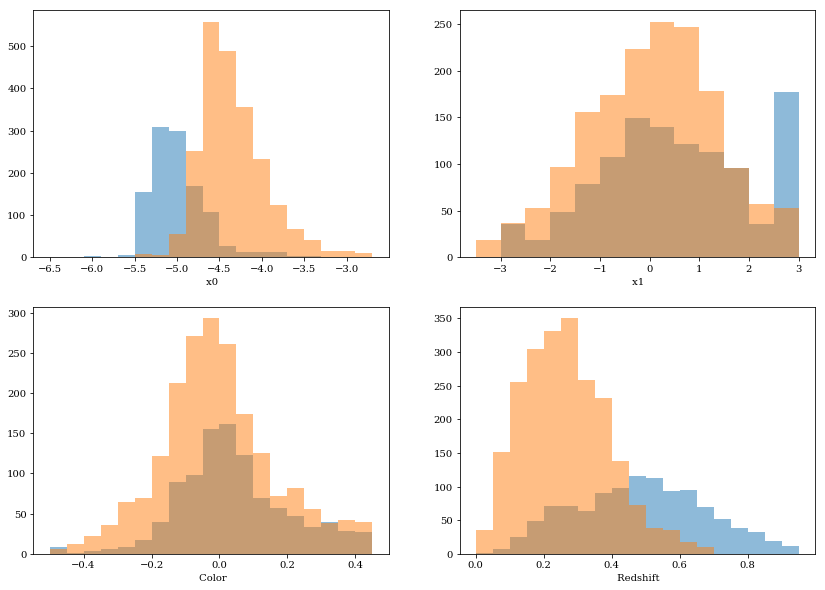

In [110]:
fig=plt.figure(1, figsize=(14,10))
b=np.arange(-6.5,-2.5,0.2)
plt.subplot(221)
plt.hist(X_training[:,1], alpha=0.5, bins=b)
plt.hist(X_testing[:,1], alpha=0.5, bins=b)
plt.xlabel(' x0')
plt.subplot(222)
b=np.arange(-3.5,+3.5,0.5)
plt.hist(X_training[:,2], alpha=0.5, bins=b)
plt.hist(X_testing[:,2], alpha=0.5, bins=b)
plt.xlabel(' x1')
plt.subplot(223)
b=np.arange(-0.5,+0.5,0.05)
plt.hist(X_training[:,3], alpha=0.5, bins=b)
plt.hist(X_testing[:,3], alpha=0.5, bins=b)
plt.xlabel(' Color')
plt.subplot(224)
b=np.arange(0,1,0.05)
plt.hist(X_training[:,0], alpha=0.5, bins=b)
plt.hist(X_testing[:,0], alpha=0.5, bins=b)
plt.xlabel(' Redshift')

Text(0.5,0,u'rescaled Redshift')

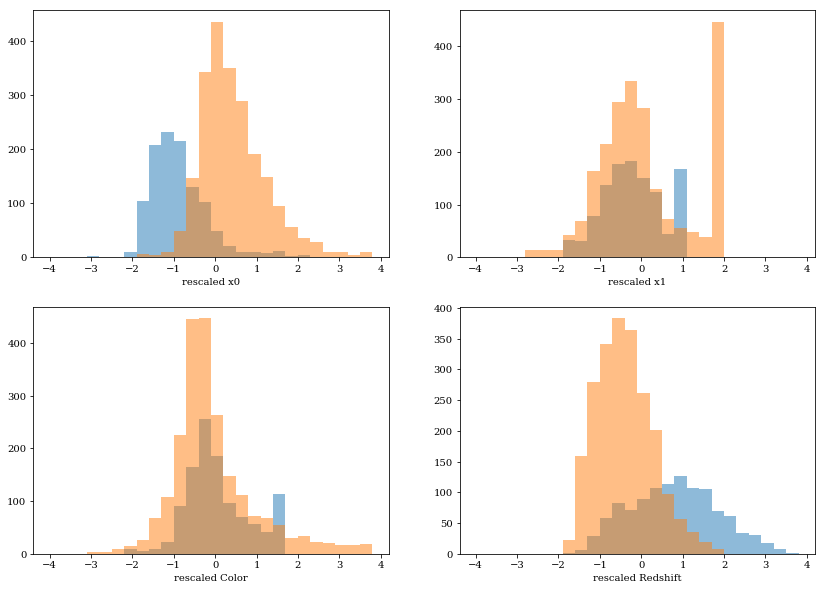

In [111]:
b=np.arange(-4,+4,0.3)
fig=plt.figure(1, figsize=(14,10))
plt.subplot(221)
plt.hist(X_training_scaled[:,1], alpha=0.5, bins=b)
plt.hist(X_testing_scaled[:,1], alpha=0.5, bins=b)
plt.xlabel('rescaled x0')
plt.subplot(222)
plt.hist(X_training_scaled[:,2], alpha=0.5, bins=b)
plt.hist(X_testing_scaled[:,2], alpha=0.5, bins=b)
plt.xlabel('rescaled x1')
plt.subplot(223)
plt.hist(X_training_scaled[:,3], alpha=0.5, bins=b)
plt.hist(X_testing_scaled[:,3], alpha=0.5, bins=b)
plt.xlabel('rescaled Color')
plt.subplot(224)
plt.hist(X_training_scaled[:,0], alpha=0.5, bins=b)
plt.hist(X_testing_scaled[:,0], alpha=0.5, bins=b)
plt.xlabel('rescaled Redshift')

In [113]:

X_training_noz=np.array(np.vstack((feats_log10[:,30],\
                               feats_log10[:,32],\
                               feats_log10[:,34],\
                              )), dtype=float).T

Y_training_noz=np.array(feats_log10[:,1], dtype=float)
   
Y_training_noz[(Y_training_noz==21) | (Y_training_noz==22) | (Y_training_noz==23)]=2
Y_training_noz[(Y_training_noz==32) | (Y_training_noz==33)]=3

feats_SDSS_noz = np.vstack((
                        np.log10(SALT_x0_SDSS), \
                        SALT_x1_SDSS,\
                        SALT_color_SDSS))


X_testing_noz=feats_SDSS_noz.T

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_noz, X_testing_noz))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_noz_scaled = scale_data(X_training_noz, global_mean, global_std)
X_testing_noz_scaled = scale_data(X_testing_noz, global_mean, global_std)

print (X_training_noz.shape)
print (Y_training_noz.shape)
print (X_testing_noz.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing set
classifier.fit(X_training_noz_scaled, Y_training_noz)
probs_noz=classifier.predict_proba(X_testing_noz_scaled)    



(1120, 3)
(1120,)
(2230, 3)


In [114]:
P_ia_ML_noz=probs_noz[:,0]
type_classif_noz=np.array([1+np.argmax([probs_noz[i,0], probs_noz[i,1], probs_noz[i,2]])\
                             for i in range(len(probs_noz[:,0]))])


(35.7, 45)

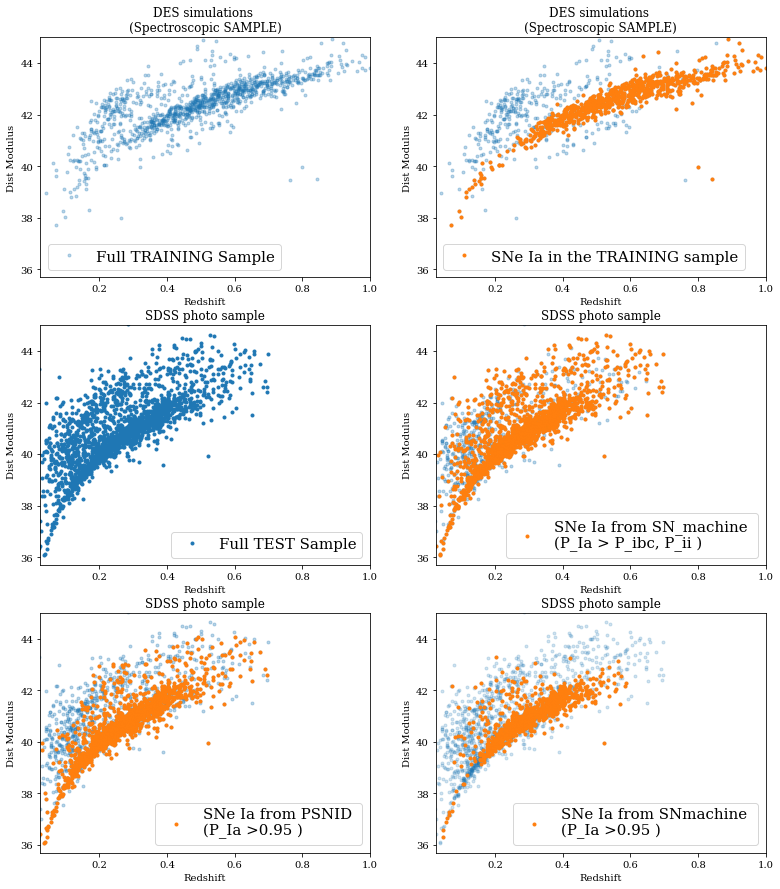

In [127]:
#### 
filterML_noz=P_ia_ML_noz>0.95
filterML_highestP_noz=type_classif_noz==1
filterPSNID_noz=P_ia_PSNID>0.95
filtertraining_noz= Y_training_noz == 1


fig=plt.figure(1,figsize=(13,15))
plt.subplot(323)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS, '.', label='Full TEST Sample')
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')
plt.subplot(326)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS, '.', alpha=0.2)
plt.plot(z_SDSS[filterML_noz], mu_SDSS[filterML_noz],\
         '.', label='SNe Ia from SNmachine \n(P_Ia >0.95 )')
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

mu_training=30.-2.5*X_training[:,1]+0.26*X_training[:,2]-3.*X_training[:,3]
plt.subplot(321)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training, '.', alpha=0.3, label='Full TRAINING Sample')
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')
plt.subplot(322)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_training, '.', alpha=0.3)
plt.plot(X_training[:,0][filtertraining_noz], mu_training[filtertraining_noz],\
         '.', label='SNe Ia in the TRAINING sample')
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')

plt.subplot(325)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS, '.', alpha=0.3)
plt.plot(z_SDSS[filterPSNID_noz], mu_SDSS[filterPSNID_noz],\
         '.', label='SNe Ia from PSNID \n(P_Ia >0.95 )')
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')


plt.subplot(324)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS, '.', alpha=0.3)
plt.plot(z_SDSS[filterML_highestP_noz], mu_SDSS[filterML_highestP_noz],\
         '.', label='SNe Ia from SN_machine \n(P_Ia > P_ibc, P_ii )')
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1)
plt.ylim(35.7,45)
#plt.xscale('log')




In [116]:
data_results=np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/DES_UNBLIND_KEY/DES_UNBLIND+HOSTZ.KEY'\
                           , dtype=None, names=True)



In [117]:
### build a representative training sample
import random
feats_log10_TEST = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_TEST_sample_log10x0_mb_cov.txt',\
                            dtype='str', comments='#')

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]


feats_log10_REPRESENTATIVE = np.array([feats_log10_TEST[filter_nan][random.randint(0, len(feats_log10_TEST[filter_nan])-1)]\
                                       for j in range(1119)])


In [118]:
X_training_REPR=np.array(np.vstack((feats_log10_REPRESENTATIVE[:,26],\
                               feats_log10_REPRESENTATIVE[:,30],\
                               feats_log10_REPRESENTATIVE[:,32],\
                               feats_log10_REPRESENTATIVE[:,34],\
                              )), dtype=float).T

des_file_associated=feats_log10_REPRESENTATIVE[:,0]


Y_TEST_REPR_results=[]
for des_snid in des_file_associated:
    try:
        CID=int((des_snid.replace('DES_SN','')).replace('.DAT',''))
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
        Y_TEST_REPR_results.append(data_results['GENTYPE'][ind_corrispondent][0])
    except ValueError:
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
#        print (ind_corrispondent, data_results['GENTYPE'][ind_corrispondent][0])
        print ('No type for', des_snid)
        Y_TEST_REPR_results.append(np.nan)



In [119]:
len(Y_TEST_REPR_results)#HELLO MARIA YOU ARE MY FRIEND

1119

In [120]:
np.where(np.isnan(Y_TEST_REPR_results))

(array([], dtype=int64),)

In [121]:

Y_training_REPR=np.array(Y_TEST_REPR_results, dtype=float)
   
Y_training_REPR[(Y_training_REPR==21) | (Y_training_REPR==22) | (Y_training_REPR==23)]=2
Y_training_REPR[(Y_training_REPR==32) | (Y_training_REPR==33)]=3

X_testing_REPR=feats_SDSS.T

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_REPR, X_testing_REPR))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_REPR_scaled = scale_data(X_training_REPR, global_mean, global_std)
X_testing_REPR_scaled = scale_data(X_testing_REPR, global_mean, global_std)

print (X_training_REPR.shape)
print (Y_training_REPR.shape)
print (X_testing_REPR.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing_REPR set
classifier.fit(X_training_REPR_scaled, Y_training_REPR)
probs_REPR=classifier.predict_proba(X_testing_REPR_scaled)    



(1119, 4)
(1119,)
(2230, 4)


In [122]:
probs_REPR

array([[ 0.57666667,  0.33166667,  0.09166667],
       [ 0.99      ,  0.00833333,  0.00166667],
       [ 0.16      ,  0.77333333,  0.06666667],
       ..., 
       [ 0.54      ,  0.24833333,  0.21166667],
       [ 0.235     ,  0.74333333,  0.02166667],
       [ 0.01666667,  0.82833333,  0.155     ]])

In [123]:
P_ia_ML_REPR=probs_REPR[:,0]
type_classif_REPR=np.array([1+np.argmax([probs_REPR[i,0], probs_REPR[i,1], probs_REPR[i,2]])\
                             for i in range(len(probs_REPR[:,0]))])



(35.7, 47)

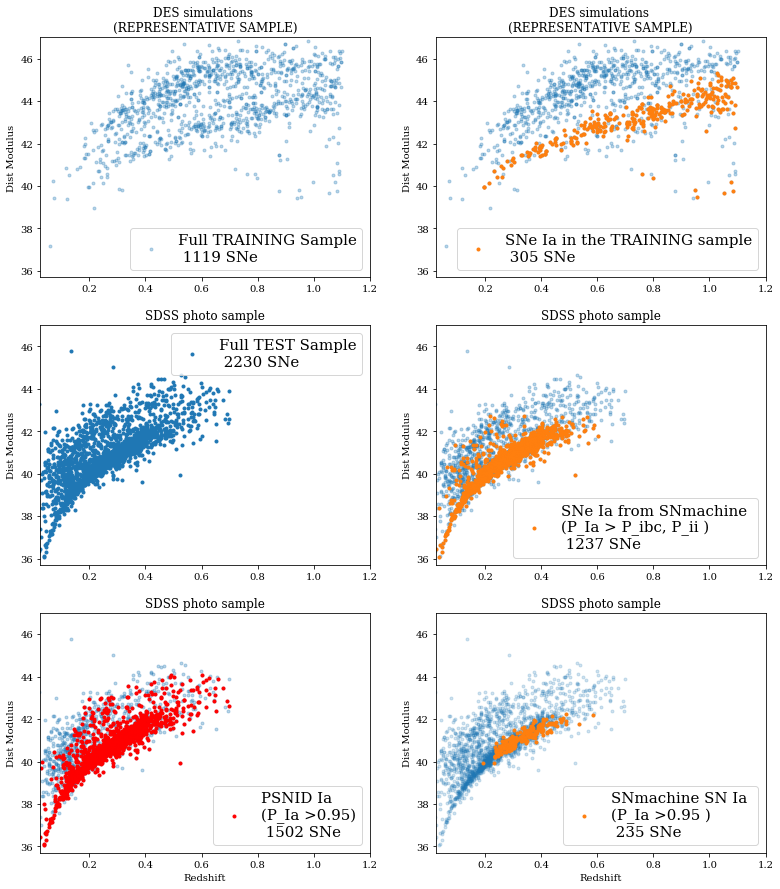

In [125]:
#### 
filterML_REPR=P_ia_ML_REPR>0.95
filterML_highestP_REPR=type_classif_REPR==1
filterPSNID_REPR=P_ia_PSNID>0.95
filtertraining_REPR= Y_training_REPR == 1


fig=plt.figure(1,figsize=(13,15))
plt.subplot(323)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS,\
         '.', label='Full TEST Sample\n %i SNe'%len(mu_SDSS))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1.2)
plt.ylim(35.7,47)
#plt.xscale('log')
plt.subplot(326)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS, '.', alpha=0.2)
plt.plot(z_SDSS[filterML_REPR], mu_SDSS[filterML_REPR],\
         '.', label='SNmachine SN Ia \n(P_Ia >0.95 )\n %i SNe'%len(mu_SDSS[filterML_REPR]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1.2)
plt.ylim(35.7,47)
#plt.xscale('log')

mu_training_REPR=30.-2.5*X_training_REPR[:,1]+0.26*X_training_REPR[:,2]-3.*X_training_REPR[:,3]
plt.subplot(321)
plt.title('DES simulations \n(REPRESENTATIVE SAMPLE)')
plt.plot(X_training_REPR[:,0], mu_training_REPR,\
         '.', alpha=0.3, label='Full TRAINING Sample\n %i SNe'%len(mu_training_REPR))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1.2)
plt.ylim(35.7,47)
#plt.xscale('log')
plt.subplot(322)
plt.title('DES simulations \n(REPRESENTATIVE SAMPLE)')
plt.plot(X_training_REPR[:,0], mu_training_REPR, '.', alpha=0.3)
plt.plot(X_training_REPR[:,0][filtertraining_REPR], mu_training_REPR[filtertraining_REPR],\
         '.', label='SNe Ia in the TRAINING sample\n %i SNe'%len(mu_training_REPR[filtertraining_REPR]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1.2)
plt.ylim(35.7,47)
#plt.xscale('log')

plt.subplot(325)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS, '.', alpha=0.3)
plt.plot(z_SDSS[filterPSNID_REPR], mu_SDSS[filterPSNID_REPR],\
         '.r', label='PSNID Ia \n(P_Ia >0.95)\n %i SNe'%len(mu_SDSS[filterPSNID_REPR]))
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1.2)
plt.ylim(35.7,47)
#plt.xscale('log')


plt.subplot(324)
plt.title('SDSS photo sample')
plt.plot(z_SDSS, mu_SDSS, '.', alpha=0.3)
plt.plot(z_SDSS[filterML_highestP_REPR], mu_SDSS[filterML_highestP_REPR],\
         '.', label='SNe Ia from SNmachine \n(P_Ia > P_ibc, P_ii )\n %i SNe'%len(mu_SDSS[filterML_highestP_REPR]))
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0.025,1.2)
plt.ylim(35.7,47)
#plt.xscale('log')



